# Part 2. Digit Recognition

### Using Traditional ML Classifiers (i.e. No DL)

In [27]:
import math 
import numpy as np
import cv2 as cv
import time
from scipy import stats 
from matplotlib import pyplot as plt
import skfuzzy as fuzz
import csv

In [28]:
class Region:
    def __init__(self):
        self.xm = 0
        self.ym = 0
        self.xx = 0
        self.yy = 0
        self.xy = 0
        self.xxx = 0
        self.yyy = 0
        self.xxy = 0
        self.xyy = 0
        self.Perimetro = 0
        self.Area = 0
        self.closed = False
        self.edgePoints = []
        self.red = 0
        self.green = 0
        self.blue = 0
    def addPoint(self,x,y,isedge,color):
        self.xm = self.xm + x
        self.ym = self.ym + y
        self.xx = self.xx + x*x
        self.yy = self.yy + y*y
        self.xy = self.xy + x*y
        self.xxx = self.xxx + x*x*x
        self.yyy = self.yyy + y*y*y
        self.xxy = self.xxy + x*x*y
        self.xyy = self.xyy + x*y*y
        self.Area = self.Area + 1
        self.red = self.red + color[0]
        self.green = self.green + color[1]
        self.blue = self.blue + color[2]

        if isedge > 0:
#            self.edgePoints.append((x+0.5,y+0.5))
            self.Perimetro = self.Perimetro + 1
            if (isedge & 1) > 0: #up
                self.edgePoints.append((x+0.5,y+0.001))
            if (isedge & 2) > 0: #left
                self.edgePoints.append((x+0.001,y+0.5))
            if (isedge & 4) > 0: #down
                self.edgePoints.append((x+0.5,y+0.999))
            if (isedge & 8) > 0: #right
                self.edgePoints.append((x+0.999,y+0.5))
    def addRegion(self,region):
        if (self.closed == False) and (region.closed == False) and (region.Area > 0):
            self.xm = self.xm + region.xm
            self.ym = self.ym + region.ym
            self.xx = self.xx + region.xx
            self.yy = self.yy + region.yy
            self.xy = self.xy + region.xy
            self.xxx = self.xxx + region.xxx
            self.yyy = self.yyy + region.yyy
            self.xxy = self.xxy + region.xxy
            self.xyy = self.xyy + region.xyy
            self.Area = self.Area + region.Area
            self.Perimetro = self.Perimetro + region.Perimetro
            self.red = self.red + region.red
            self.green = self.green + region.green
            self.blue = self.blue + region.blue
            for n in range(len(region.edgePoints)):
                self.edgePoints.append(region.edgePoints[n])
    def closeRegion(self):
        if (self.Area > 0) and (self.closed == False):
            self.xm = self.xm/self.Area
            self.ym = self.ym/self.Area
            self.xx = self.xx/self.Area - self.xm*self.xm
            self.yy = self.yy/self.Area - self.ym*self.ym
            self.xy = self.xy/self.Area - self.xm*self.ym
            self.red = self.red/self.Area
            self.green = self.green/self.Area
            self.blue = self.blue/self.Area
            self.closed = True
        

In [29]:
def smoothPointSet(points,steps):
    lpts = len(points)
    for stp in range(steps):
        apt = np.array(points)
        for n in range(lpts):
            bidx = (n + lpts - 1) % lpts
            uidx = (n + lpts + 1) % lpts
            points[n] = ((apt[bidx][0]+apt[n][0]+apt[uidx][0])/3,(apt[bidx][1]+apt[n][1]+apt[uidx][1])/3)
    return points
    

In [30]:
def perimeterPointSet(points):
    per = 0
    llist = len(points)
    euler = 2 - llist
    avgrad = 0
    cx = 0 
    cy = 0
    tpts = 0
    minx = 10000
    miny = 10000
    maxx = 0
    maxy = 0
    minrad = 10000
    maxrad = 0
    for ln in range(llist):
        cpts = points[ln]
        lpts = len(cpts)
        apt = np.array(points[ln])
        for n in range(lpts):
            cx = cx + apt[n][0]
            cy = cy + apt[n][1]
            tpts = tpts  + 1
            if minx > apt[n][0]:
                minx = apt[n][0]
            if miny > apt[n][1]:
                miny = apt[n][1]
            if maxx < apt[n][0]:
                maxx = apt[n][0]
            if maxy < apt[n][1]:
                maxy = apt[n][1]
    cx =  cx/tpts       
    cy =  cy/tpts       

    for ln in range(llist):
        cpts = points[ln]
        lpts = len(cpts)
        apt = np.array(points[ln])
        for n in range(lpts):
            nidx = (n + lpts + 1) % lpts
            dx = apt[nidx][0]-apt[n][0]
            dy = apt[nidx][1]-apt[n][1]
            per = per + math.sqrt(dx**2 + dy**2)
            dx = apt[n][0]-cx
            dy = apt[n][1]-cy
            distoctr = math.sqrt(dx**2 + dy**2)
            avgrad = avgrad + distoctr
            if minrad > distoctr:
                minrad = distoctr
            if maxrad < distoctr:
                maxrad = distoctr
            
    avgrad = avgrad/tpts
    return per, euler, avgrad, cx, cy, tpts, minx, miny, maxx, maxy, minrad, maxrad

In [31]:
def orderPointSet(opoints,EdgeImage):
    orderpointsList = []
    if len(opoints) > 0:
        points = opoints.copy()
        neigbors = np.array([(1,0),(1,1),(0,1),(-1,1),(-1,0),(-1,-1),(0,-1),(1,-1),(0,0)])*0.5
        plen = len(points)
        n = 0
        last = 0
        inserted = 0
        orderpoints = []
        orderpoints.append(points[0])
        points.pop(0)
        lastidx = 0
        who = 0
        for inserted in range(plen-1):
            n = 0
            cpt = np.array(orderpoints[last])
            edgetype = EdgeImage[int(cpt[1]),int(cpt[0])]
            dis = 1
            thepoints = np.array(points)                
            thesum = np.sum(abs(thepoints-cpt),axis=1)
            lastdir = np.sum(np.square(neigbors-neigbors[lastidx]),axis=1)
            dis = 10
            idx = lastidx;
            for n in range(len(points)):
                if thesum[n] <= 2:
                    npoints = cpt + neigbors
                    theNsum = np.sum(np.abs(npoints-thepoints[n]),axis=1) + 0.01*lastdir
                    for nn in range(8):
                        nedgetype = EdgeImage[int(npoints[nn,1]),int(npoints[nn,0])]
                        dist = theNsum[nn] + 0.001*((edgetype ^ nedgetype) > 0)
                        if dist < dis:
                            dis = dist
                            idx = nn
                            who = n
            if dis < 1.0:
                lastidx = idx
                orderpoints.append(points[who])
                points.pop(who)
            else:
                if len(orderpoints) > 2:
                    orderpointsList.append(orderpoints)
                orderpoints = []
                orderpoints.append(points[0])
                points.pop(0)
                last = 0
            last = len(orderpoints) - 1
        if len(orderpoints) > 2:
            orderpointsList.append(orderpoints)
    return orderpointsList    

In [32]:

def SegmentationRegions(image,colorimg): 
    regions = []
    si,sj = image.shape;
    fimage = image.astype(np.int16)
    EdgeImage = image.astype(np.int16)
#    print(fimage.shape)
        
    regionlabels = image[:,:];
    regionlabels = regionlabels.astype(np.int32)
    shortlabellut = np.zeros((int(si*sj/100+1),), dtype=np.int32)
    labellut = shortlabellut
    upKernel = np.array((
    [0, -1, 0],
    [0, 1, 0],
    [0, 0, 0]), dtype=np.int16)
    upsameI = abs(cv.filter2D(fimage,-1,upKernel)) == 0  
    leftKernel = np.array((
    [0, 0, 0],
    [-1, 1, 0],
    [0, 0, 0]), dtype=np.int16)
    leftsameI = abs(cv.filter2D(fimage,-1,leftKernel)) == 0
    downKernel = np.array((
    [0, 0, 0],
    [0, 1, 0],
    [0, -1, 0]), dtype=np.int16)
    downsameI = abs(cv.filter2D(fimage,-1,downKernel)) == 0  
    rightKernel = np.array((
    [0, 0, 0],
    [0, 1, -1],
    [0, 0, 0]), dtype=np.int16)
    rightsameI = abs(cv.filter2D(fimage,-1,rightKernel)) == 0
    currentlabel=0
    uplabelArray = regionlabels[0,:]
    upsame = False
    leftsame = False
    thelabel = 0
    uplabel = 0
    leftlabel = 0
    regions.append(Region())
    for i in range(si):
        leftlabel = labellut[regionlabels[i,0]]
        for j in range(sj):
            color = colorimg[i,j,:]
            thelabel = leftlabel 
            upsame = False
            leftsame = False
            EdgeImage[i,j] = 1*(not upsameI[i,j]) +  2*(not leftsameI[i,j]) + 4*(not downsameI[i,j]) + 8*(not rightsameI[i,j])
            if i>0:
                uplabel = uplabelArray[j]
                upsame = upsameI[i,j]
                if upsame:
                    thelabel = uplabel
            if j>0:
                leftsame = leftsameI[i,j]
                if leftsame:
                    if thelabel > leftlabel:
                        thelabel = leftlabel                
                    if upsame:
                        thelabel = labellut[thelabel]
                        labellut[leftlabel] = thelabel
                        labellut[uplabel] = thelabel
            if (not(upsame) and  not(leftsame)):
                currentlabel = currentlabel + 1
                regions.append(Region())
                thelabel = currentlabel
                if (currentlabel >= labellut.size):
                    labellut = np.append(labellut, shortlabellut)
                labellut[currentlabel] = currentlabel
            else:
                thelabel = labellut[thelabel]
            regionlabels[i,j] = thelabel
            regions[thelabel].addPoint(j,i,EdgeImage[i,j],color)
            leftlabel = thelabel
        uplabelArray = regionlabels[i,:]
    print(len(regions))
    lreg = len(regions)
    changes = 1
    while changes > 0:
        changes = 0
        for idx in range(lreg):
            newlabel = labellut[idx]
            if regions[idx].Area > 0 and idx != newlabel:
                changes = changes + 1
                regions[newlabel].addRegion(regions[idx])
                regions[idx].__init__()
            labellut[idx] = labellut[newlabel]
        print(changes)
    closed = 0
    for n in range(lreg):
        if (n == labellut[n]) and (regions[n].Area > 0):
            closed = closed + 1
            regions[n].closeRegion()
    print(closed)
    regionlabels = labellut[regionlabels];
    return regionlabels, regions, EdgeImage


In [33]:

def regionsConv(image,t):
    regions = []
    si,sj,ch = image.shape;
    fimage = image.astype(np.int16)
#    print(fimage.shape)
    if t < 0:
        fimage = image.astype(float)
        meanKernel = np.ones((5,5), dtype=float)/25.0
        meanimage = cv.filter2D(fimage,-1,meanKernel)
        sdev = np.sqrt(abs(cv.filter2D(fimage*fimage,-1,meanKernel) - meanimage*meanimage))
        for dd in range(ch):
            lowlim = np.percentile(sdev[:,:,dd], 10, interpolation = 'midpoint')  + 1.0
            sdev[:,:,dd] = np.maximum(sdev[:,:,dd],lowlim)
            uperlim = np.percentile(sdev[:,:,dd], 75, interpolation = 'midpoint') 
            sdev[:,:,dd] = np.minimum(sdev[:,:,dd],uperlim)
        kernel = np.ones((3,3),np.uint8)
        sdev = cv.erode(sdev,kernel,iterations = 4)
        sdev = cv.filter2D(sdev,-1,meanKernel)
        sdev = cv.erode(sdev,kernel,iterations = 1)
        sdev = cv.filter2D(sdev,-1,meanKernel)
        sdev = cv.erode(sdev,kernel,iterations = 1)

        img = cv.normalize(sdev, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
        RGB_im = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        plt.imshow(RGB_im)
        plt.title('STDEV')
        plt.show()
        fimage = fimage/sdev
        img = cv.normalize(fimage, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
        RGB_im = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        plt.imshow(RGB_im)
        plt.title('Z')
        plt.show()

        t = abs(t)
        
    regionlabels = image[:,:,0];
    regionlabels = regionlabels.astype(np.int32)
    shortlabellut = np.zeros((int(si*sj/100+1),), dtype=np.int32)
    labellut = shortlabellut
    upKernel = np.array((
    [0, -1, 0],
    [0, 1, 0],
    [0, 0, 0]), dtype=np.int16)
    updiff = np.max(abs(cv.filter2D(fimage,-1,upKernel)),2) <= t  
    leftKernel = np.array((
    [0, 0, 0],
    [-1, 1, 0],
    [0, 0, 0]), dtype=np.int16)
    leftdiff = np.max(abs(cv.filter2D(fimage,-1,leftKernel)),2) <= t
    downKernel = np.array((
    [0, 0, 0],
    [0, 1, 0],
    [0, -1, 0]), dtype=np.int16)
    downdiff = np.max(abs(cv.filter2D(fimage,-1,downKernel)),2) <= t  
    rightKernel = np.array((
    [0, 0, 0],
    [0, 1, -1],
    [0, 0, 0]), dtype=np.int16)
    rightdiff = np.max(abs(cv.filter2D(fimage,-1,rightKernel)),2) <= t
    currentlabel=0
    uplabelArray = regionlabels[0,:]
    upsame = False
    leftsame = False
    thelabel = 0
    uplabel = 0
    leftlabel = 0
    regions.append(Region())
    for i in range(si):
        leftlabel = labellut[regionlabels[i,0]]
        for j in range(sj):
            thelabel = leftlabel 
            upsame = False
            leftsame = False
            isedge = False
            if i>0:
                uplabel = uplabelArray[j]
                upsame = updiff[i,j]
                if upsame:
                    thelabel = uplabel
            if j>0:
                leftsame = leftdiff[i,j]
                if leftsame:
                    if thelabel > leftlabel:
                        thelabel = leftlabel                
                    if upsame:
                        thelabel = labellut[thelabel]
                        labellut[leftlabel] = thelabel
                        labellut[uplabel] = thelabel
            if (not(upsame) and  not(leftsame)):
                isedge = True
                currentlabel = currentlabel + 1
                regions.append(Region())
                thelabel = currentlabel
                if (currentlabel >= labellut.size):
                    labellut = np.append(labellut, shortlabellut)
                labellut[currentlabel] = currentlabel
            else:
                thelabel = labellut[thelabel]
            regionlabels[i,j] = thelabel
            regions[thelabel].addPoint(j,i,False)
            leftlabel = thelabel
        uplabelArray = regionlabels[i,:]
    print(labellut.size)
    print(len(regions))
    merged=labellut
    lreg = len(regions)
    while True:
        for n in range(lreg):
            if (merged[n] >= 0) and (n != labellut[n]):
                regions[labellut[n]].addRegion(regions[n])
                merged[n] = -1
        orlut=labellut
        labellut=labellut[labellut];
        print(abs(orlut-labellut).sum())
        if abs(orlut-labellut).sum() == 0:
            break
    closed = 0
    for n in range(lreg):
        if n == labellut[n]:
            closed = closed + 1
            regions[n].closeRegion()
    print(closed)
    regionlabels = labellut[regionlabels];
    return regionlabels, regions


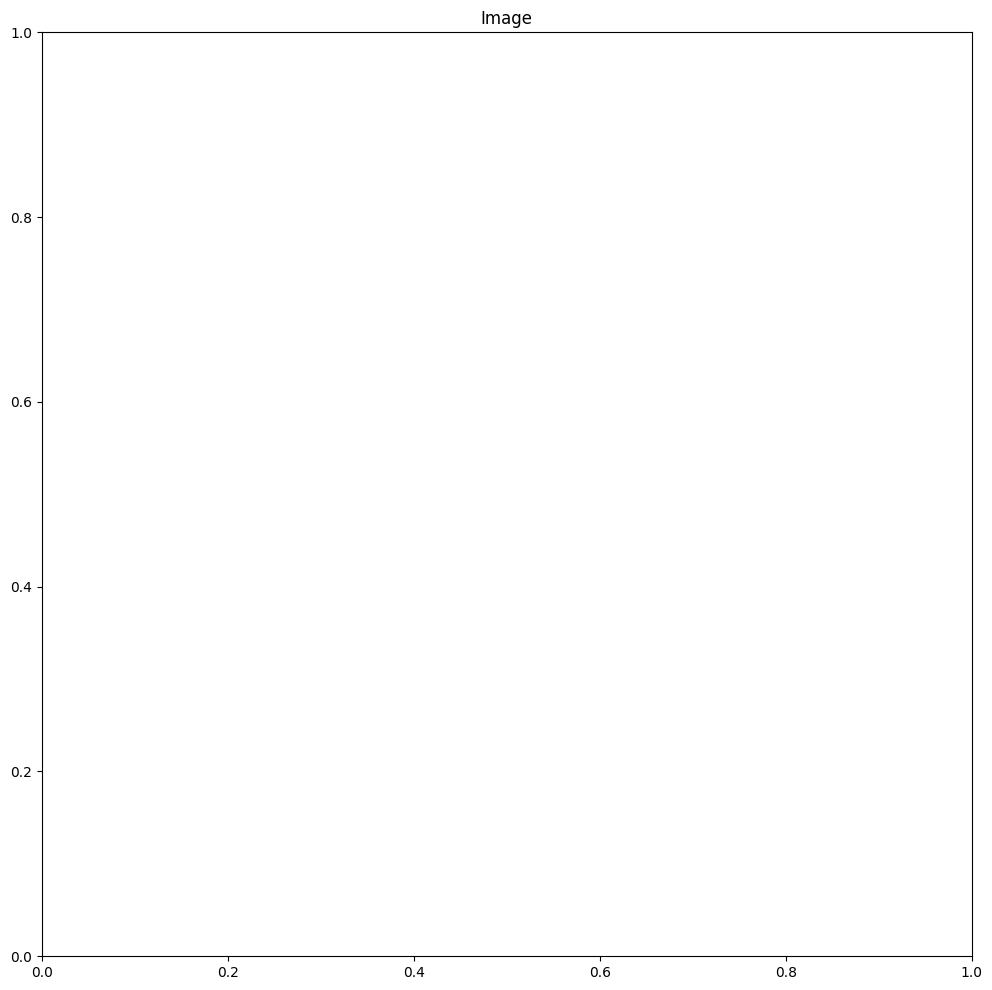

In [34]:
import os
frame = cv.imread(os.path.join('digits', '1.jpeg'))
featuresfile = open('number_1.csv', 'w',newline='')

RGB_im = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

#plt.imshow(RGB_im)
#plt.imshow(frame)
fig = plt.gcf() 
fig.set_size_inches(12,12, forward=True)
plt.title('Image')
#plt.show()
t0= time.time()

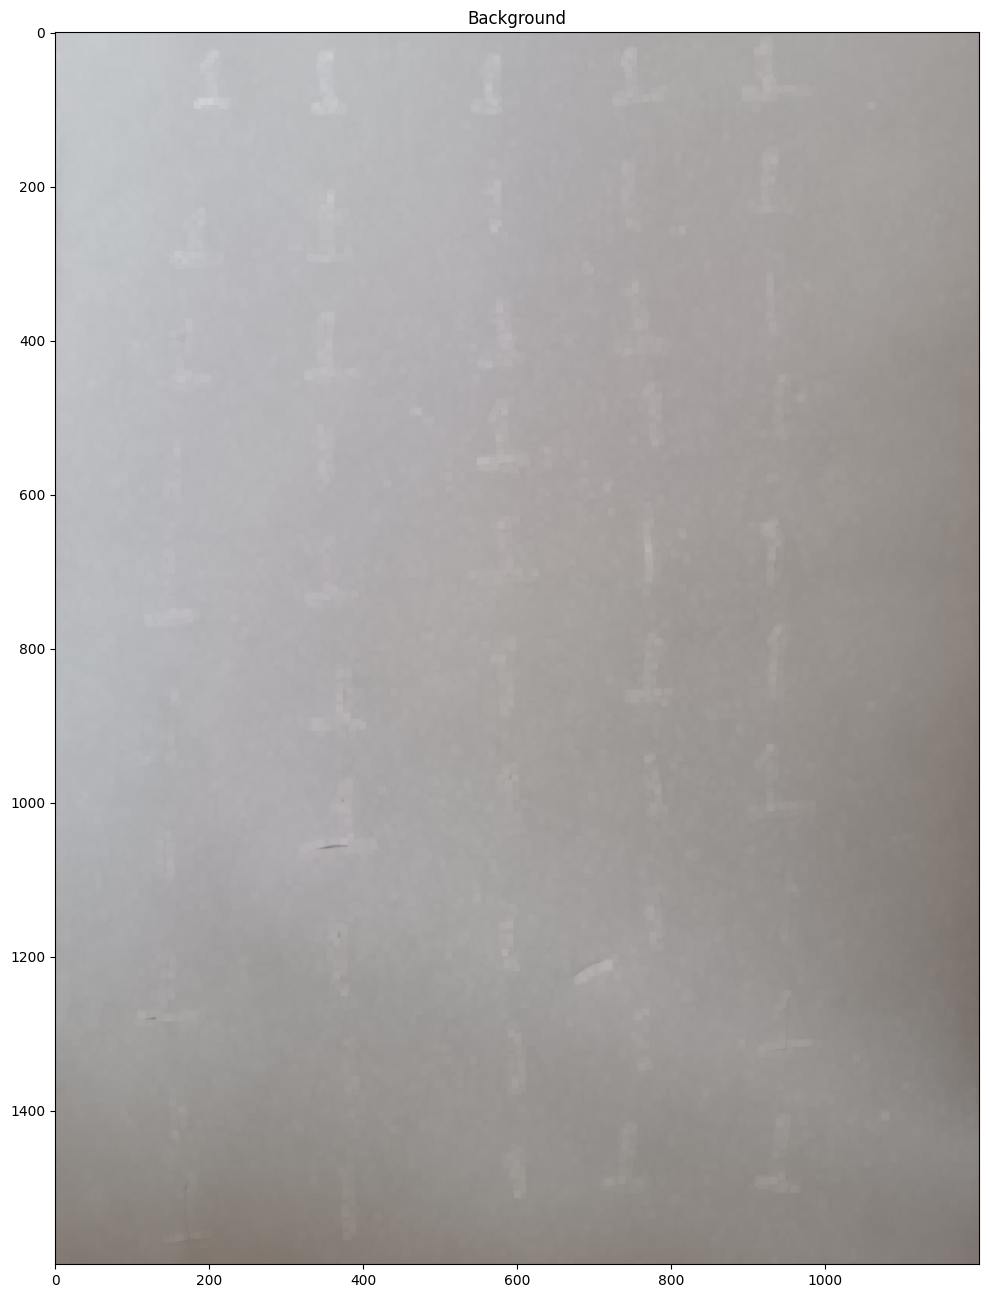

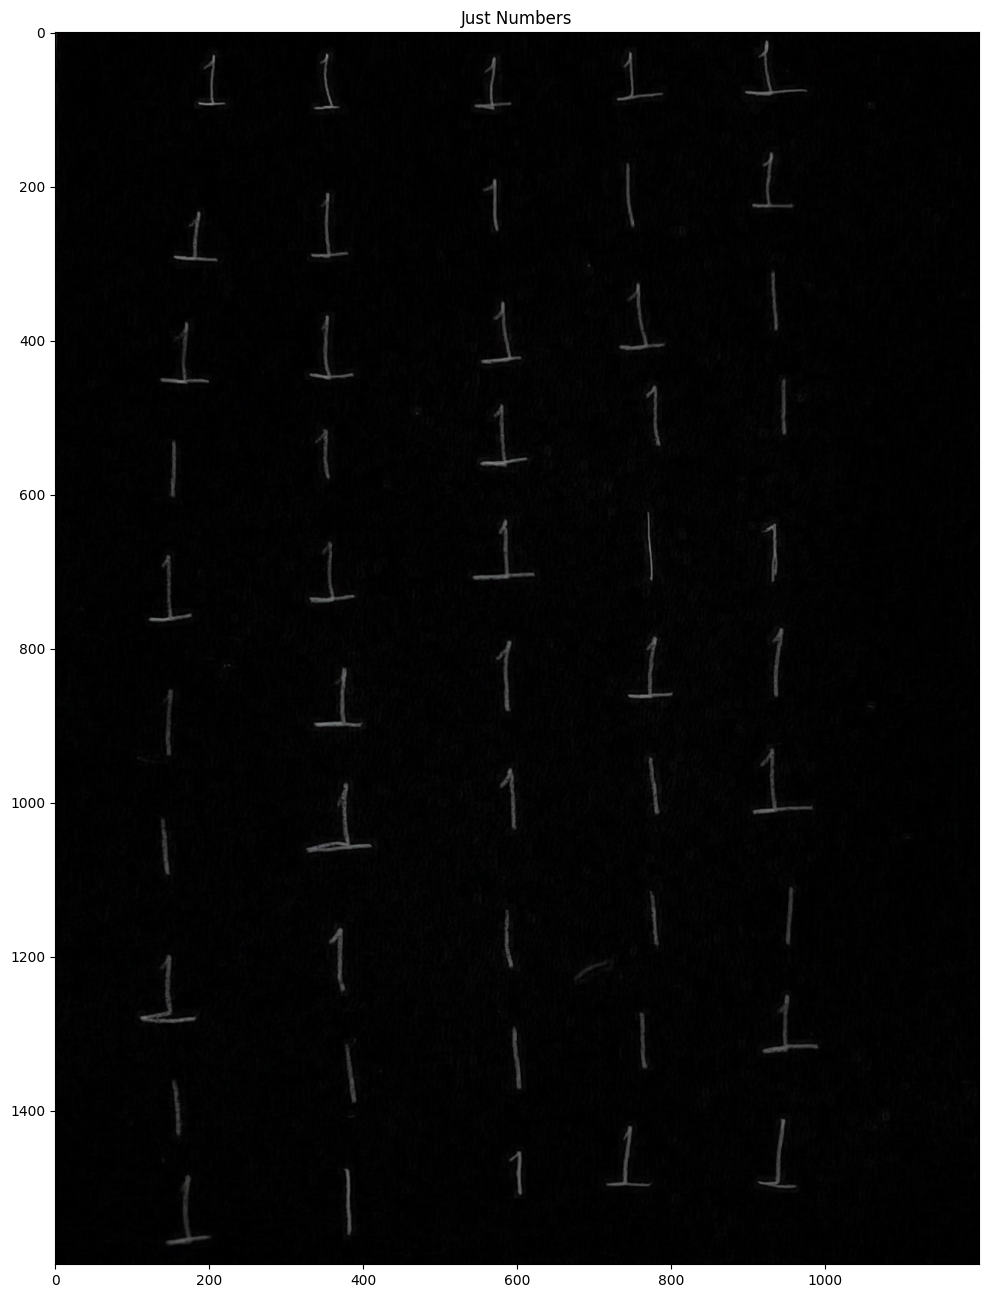

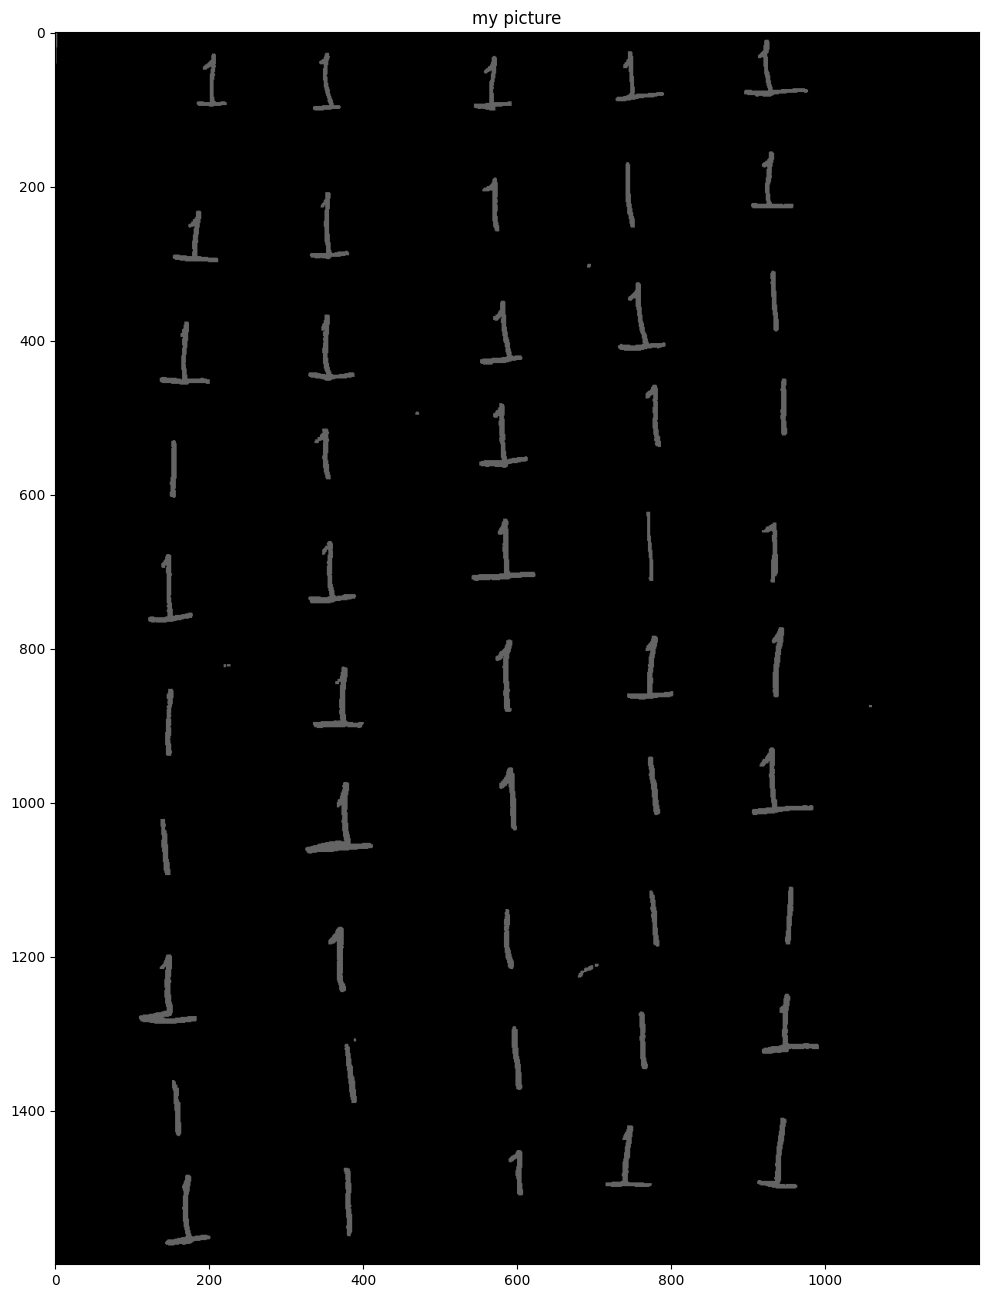

In [35]:

kernel = np.ones((5,5),np.uint8)
bkgnd = cv.dilate(frame,kernel,iterations = 1)
bkgnd = cv.dilate(bkgnd,kernel,iterations = 1)

RGB_im = cv.cvtColor(bkgnd, cv.COLOR_BGR2RGB)
fig = plt.gcf() 
fig.set_size_inches(16,16, forward=True)
plt.imshow(RGB_im)
plt.title('Background')
plt.show()

frame = (bkgnd - frame);

RGB_im = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
fig = plt.gcf() 
fig.set_size_inches(16,16, forward=True)
plt.imshow(RGB_im)
plt.title('Just Numbers')
plt.show()

kernel = np.ones((3,3),np.uint8)
frame = cv.dilate(frame,kernel,iterations = 1)

green = frame[:,:,2]

ret,img = cv.threshold(green, 32, 100, 0)
RGB_im = cv.cvtColor(img, cv.COLOR_BGR2RGB)
fig = plt.gcf() 
fig.set_size_inches(16,16, forward=True)
plt.imshow(RGB_im)
plt.title('my picture')
plt.show()

/tmp/ipykernel_72561/367452054.py:32: RuntimeWarning: overflow encountered in scalar add
  self.blue = self.blue + color[2]
/tmp/ipykernel_72561/367452054.py:30: RuntimeWarning: overflow encountered in scalar add
  self.red = self.red + color[0]
/tmp/ipykernel_72561/367452054.py:31: RuntimeWarning: overflow encountered in scalar add
  self.green = self.green + color[1]


1008
944
39
0
63
Time elapsed:  7.96475887298584


/tmp/ipykernel_72561/367452054.py:60: RuntimeWarning: overflow encountered in scalar add
  self.blue = self.blue + region.blue
/tmp/ipykernel_72561/367452054.py:58: RuntimeWarning: overflow encountered in scalar add
  self.red = self.red + region.red
/tmp/ipykernel_72561/367452054.py:59: RuntimeWarning: overflow encountered in scalar add
  self.green = self.green + region.green


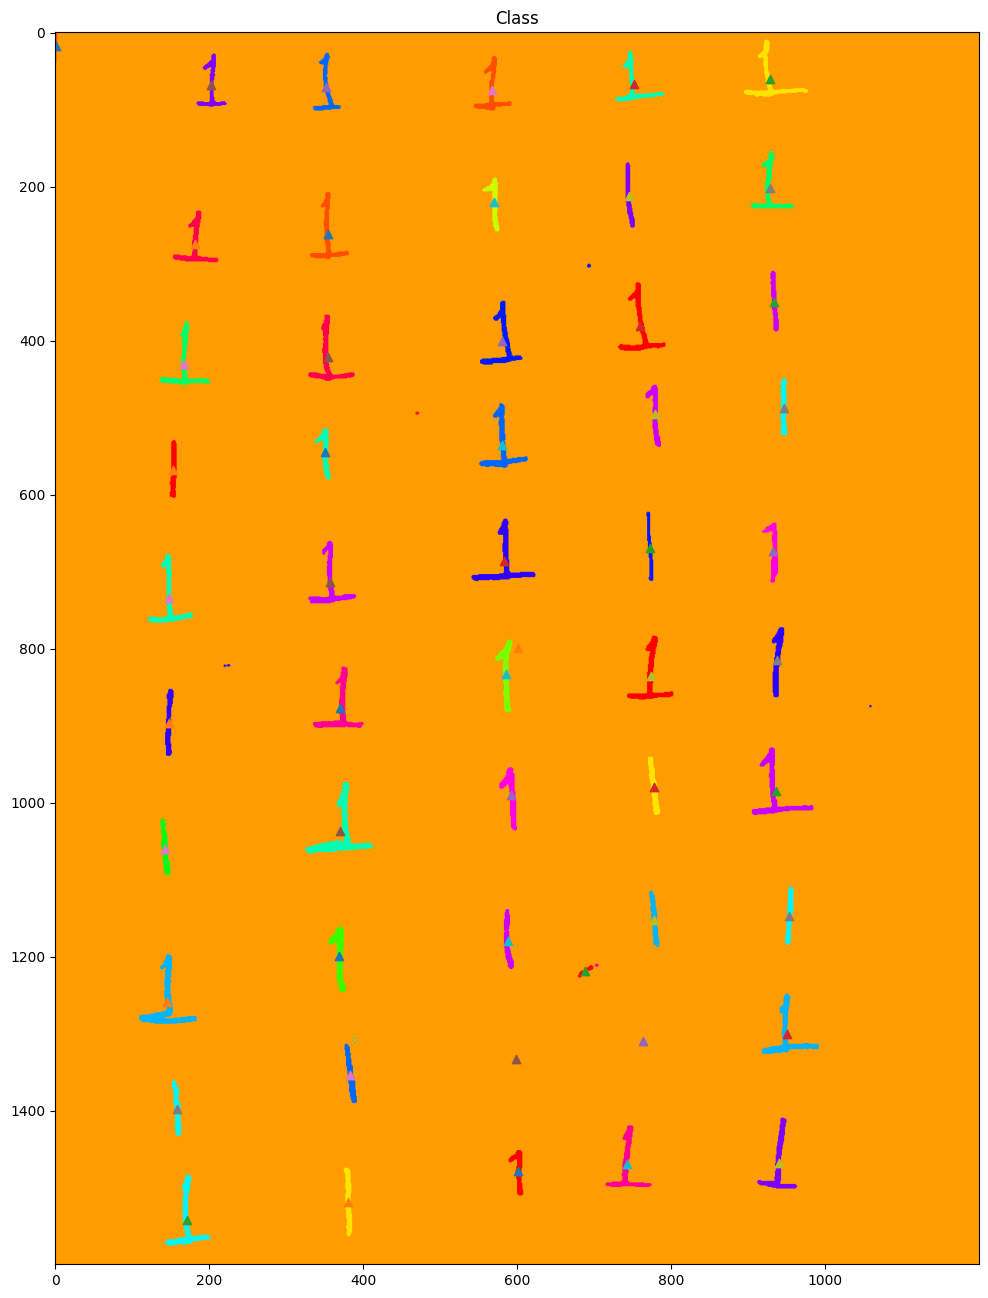

In [36]:

labeled, regions, EdgeImage = SegmentationRegions(img,frame)
t1 = time.time() - t0
print("Time elapsed: ", t1)

labeled = labeled % 21;

img = cv.normalize(labeled, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
im_color = cv.applyColorMap(img, cv.COLORMAP_HSV)
im_color = cv.medianBlur(im_color,3)
RGB_im = cv.cvtColor(im_color, cv.COLOR_BGR2RGB)
plt.imshow(RGB_im)
fig = plt.gcf() 
fig.set_size_inches(16,16, forward=True)
for n in range(len(regions)):
     if (regions[n].closed) and (regions[n].Area > 50):
        plt.scatter(regions[n].xm, regions[n].ym, marker='^')
plt.title('Class')
plt.show()



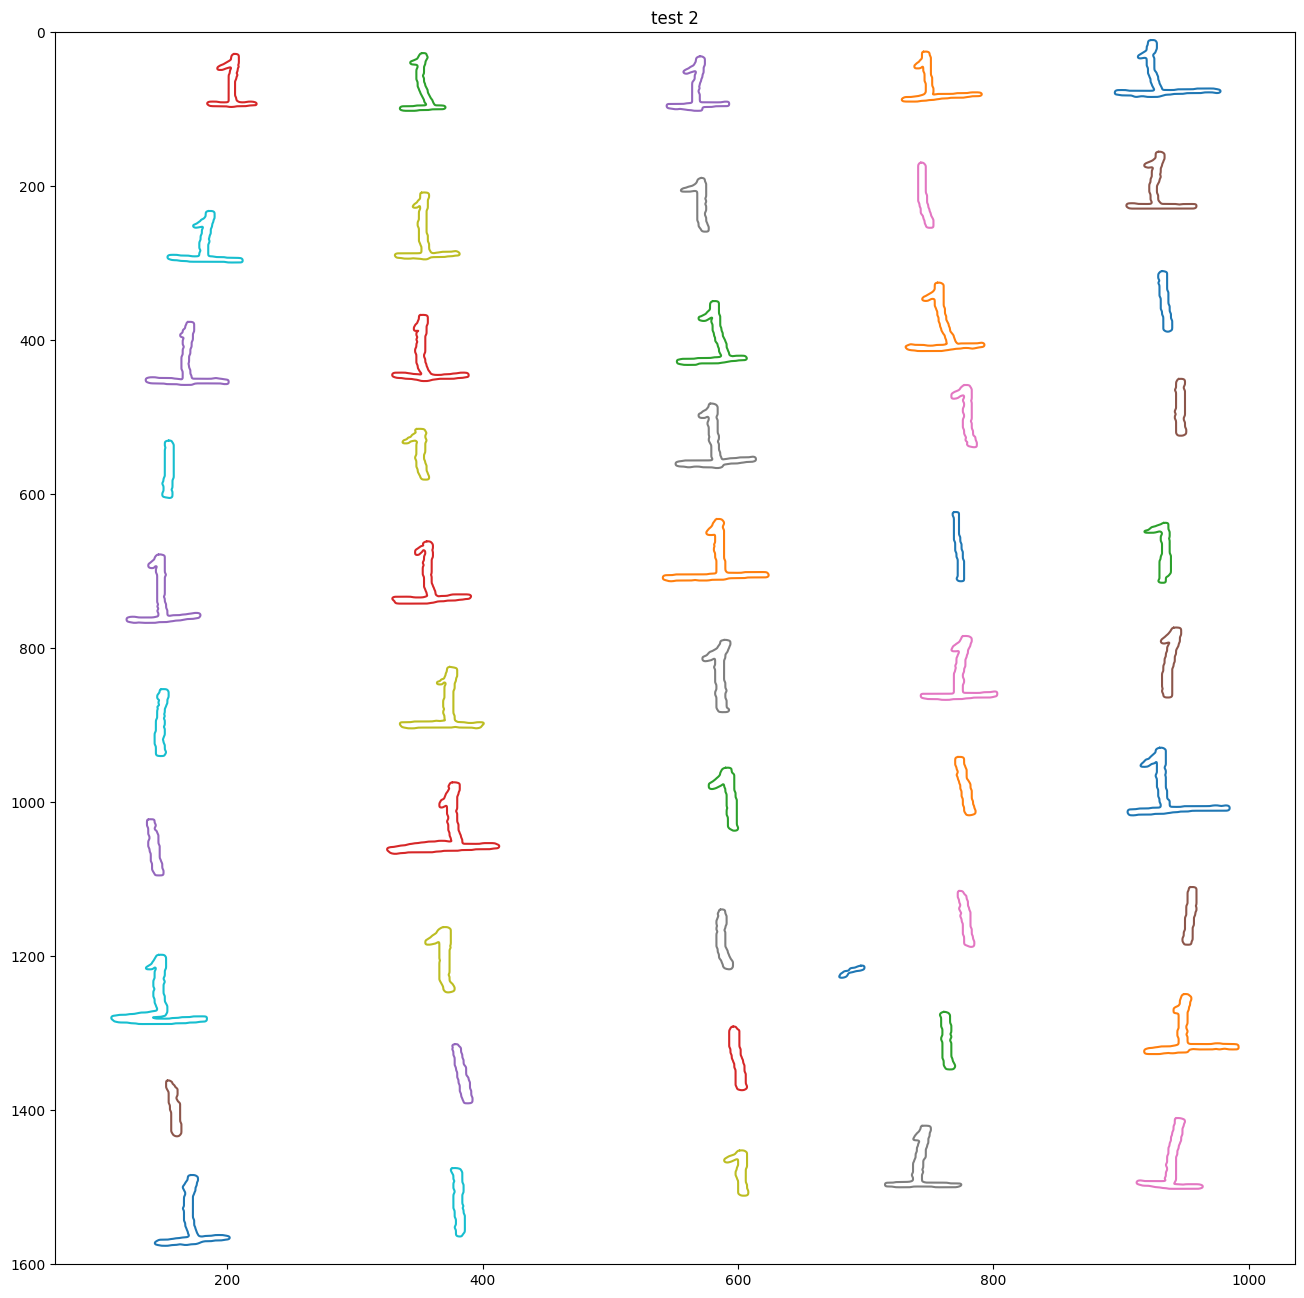

In [37]:

fig, ax = plt.subplots()
fig.set_size_inches(16,16, forward=True)

for n in range(len(regions)-2):
    idx = n+2
    if regions[idx].Area > 50:
        if regions[idx].Area < 10000:
            pointlist = orderPointSet(regions[idx].edgePoints,EdgeImage)
            smoothpoints = np.array(smoothPointSet(pointlist[0],3))
            ax.plot(smoothpoints[:,0],smoothpoints[:,1])
ax.set_ylim(frame.shape[0],0)
plt.title('test 2')
plt.show()


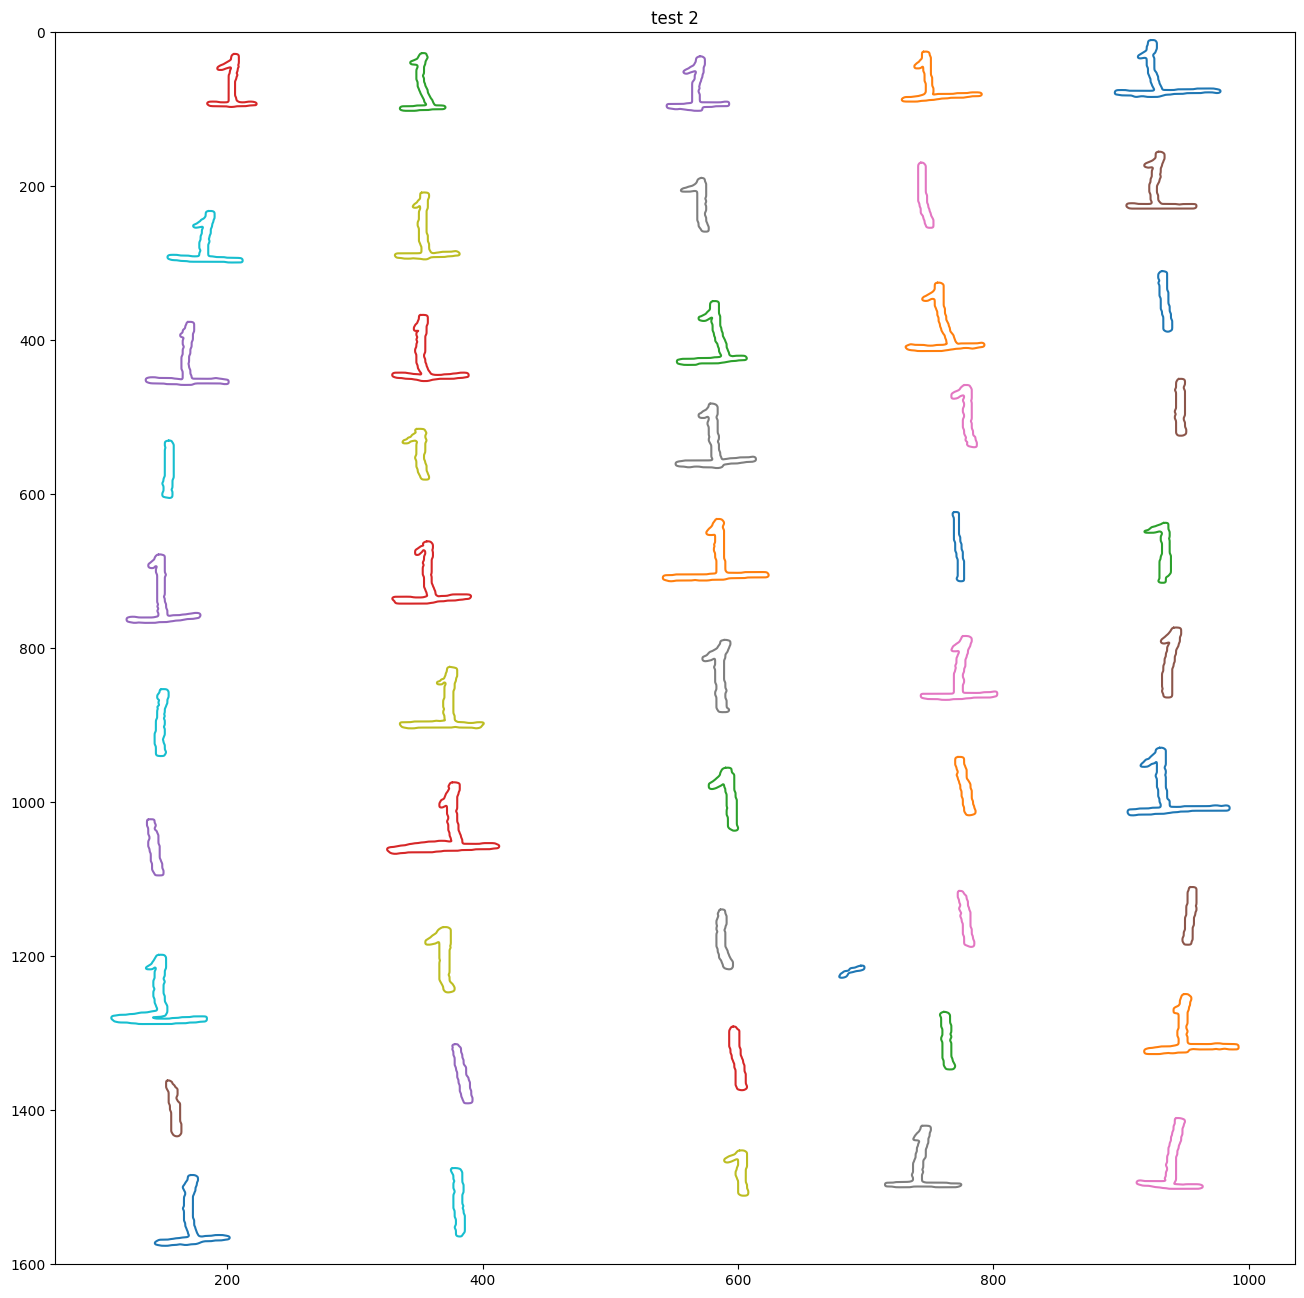

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(16,16, forward=True)

for n in range(len(regions)-2):
    idx = n+2
    if regions[idx].Area > 50:
        if regions[idx].Area < 10000:
            pointlist = orderPointSet(regions[idx].edgePoints,EdgeImage)
            smoothpoints = np.array(smoothPointSet(pointlist[0],3))
            ax.plot(smoothpoints[:,0],smoothpoints[:,1])
ax.set_ylim(frame.shape[0],0)
plt.title('test 2')
plt.show()


In [39]:
writer = csv.writer(featuresfile)
colnames=["Area","Perimetro","xm","ym","xx","yy","xy","red","green","blue"]
colnames=np.append(colnames,["per","euler","avgrad","cx","cy","tpts","minx","miny","maxx","maxy","minrad","maxrad"])
colnames=np.append(colnames,["Comp","SxxyyR","SxyxxR","SxyyyR"])
colnames=np.append(colnames,["Comp2","tpPerR","AvgPerR","DimXYR","minMaxR"])
writer.writerow(colnames)
for n in range(len(regions)-2):
    idx = n+2
    if regions[idx].Area > 50:
        if regions[idx].Area < 10000:
            pointlist = orderPointSet(regions[idx].edgePoints,EdgeImage)
            smoothpoints = np.array(smoothPointSet(pointlist[0],3))
            per, euler, avgrad, cx, cy, tpts, minx, miny, maxx, maxy, minrad, maxrad = perimeterPointSet(pointlist)
            rowfeature = [regions[idx].Area,regions[idx].Perimetro,regions[idx].xm,regions[idx].ym,regions[idx].xx,regions[idx].yy,regions[idx].xy,regions[idx].red,regions[idx].green,regions[idx].blue]
            rowfeature = np.append(rowfeature,[per, euler, avgrad, cx, cy, tpts, minx, miny, maxx, maxy, minrad, maxrad])
            rowfeature = np.append(rowfeature,[regions[idx].Area/regions[idx].Perimetro**2,regions[idx].xx/regions[idx].yy,regions[idx].xy/regions[idx].xx,regions[idx].xy/regions[idx].yy])
            rowfeature = np.append(rowfeature,[regions[idx].Area/per**2,tpts/per,avgrad/per,(maxx-minx)/(maxy-miny),minrad/maxrad])
            writer.writerow(rowfeature)
featuresfile.close()